In [1]:
### If you haven't yet installed wot, uncomment and run the line below:
#!pip install -q wot

### We begin by importing some useful python packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wot

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Notebook 2: Computing transport matrices

In this notebook we compute transport matrices connecting each pair of time-points, and we examine the effect of each parameter on the solution. 

To compute the transport matrix $\pi_{t_1,t_2}$ connecting cells $x_1, \ldots, x_n$ at time $t_1$ to cells $y_1, \ldots, y_m$ at time $t_2$, we solve an optimization problem over all matrices $\pi$ that obey certain row-sum and column-sum constraints. 
These constraints ensure that the total amount of mass flowing out of each cell $x_i$ and into each cell $y_j$ adds up the correct amount. 
We select the transport matrix with the lowest possible transport cost, subject to these constraints. 

The amount of mass flowing out of each cell $x_i$ depends on the *growth rate* of the cell. We do this in step 1 below, before proceeding to computing transport maps in step 2. 


# Step 1: Construct initial estimate of cell growth rates (optional)

Before computing transport maps, we first form an initial estimate of the cell growth rate function $g(x)$. 
We do this using signatures of proliferation and apoptosis computed in Notebook 1. 
Note that we refine this initial estimate using unbalanced optimal transport, as explained later in this notebook. 

We model cellular growth with a Birth-Death Process, which assigns each cell $x$ a *rate* of division $\beta(x)$ and a  rate of death $\delta(x)$. 
In a small interval of time $dt$, these *rates* imply that the probability of a division is $\beta(x)dt$, and the probability of death is $\delta(x) dt$. 
The expected number of descendants after time $dt = t_2 - t_1$ is $e^{dt(\beta(x) - \delta(x))}$.

To compute the birth (i.e. division) rate and death rate, we apply a logistic function to transform the gene set scores into biologically plausible vaules for our reprogramming dataset (where the most proliferative cells double every 9 hours, and the least proliferative cells double every 60 hours). 

In [2]:
### load proliferation and apoptosis scores
gene_set_scores = pd.read_csv('data/gene_set_scores.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

### apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

birth = beta(proliferation)
death = delta(apoptosis)

### growth rate is given by 
gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
growth_rates_df.to_csv('data/growth_gs_init.txt')

# Step 2: Compute transport maps

We are now ready to compute transport maps. 

The next code block reads in the expression matrix, cell days, and the initial cell growth rates we computed in step 1 above. If the cell growth rates are not provided, the algorithm will assume each cell grows at roughly the same rate.  Note that the expression matrix we use here contains variable gene expression data of 1,400 genes from two time-course experiments, and we apply a filter to select cells from the serum time course. 

In [4]:
VAR_GENE_DS_PATH = 'data/ExprMatrix.var.genes.loom'
CELL_DAYS_PATH = 'data/cell_days.txt'
SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'
CELL_GROWTH_PATH = 'data/growth_gs_init.txt'

### load data
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

(175472, 1479)

# The optimization problem

We solve the following *unbalanced transport* optimization problem introduced in Chizat et al 2018, where we only enforce the row-sum constraints approximately and we add entropy to the transport matrix: 

\begin{equation}
\begin{aligned}
\underset{\pi}{\text{minimize}} & \qquad \iint c(x,y) \pi(x,y) dx dy - \epsilon \int \pi(x,y) \log \pi(x,y) dx dy \\
&\qquad + \lambda_2 {\text{KL}} \left ( \int \pi(x,y) dx  \Big \vert d \hat {\mathbb{P}}_{t_2} (y) \int g(x)^{t_2 - t_1} d \hat {\mathbb{P}}_{t_1}(x) \right ) \\ 
& \qquad + \lambda_1 {\text{KL}} \left ( \int \pi(x,y) dy \Big \vert d \hat {\mathbb{P}}_{t_1} (x) g(x)^{t_2 - t_1} \right). 
\end{aligned}
\end{equation}

Here we use the notation  $\hat {\mathbb{P}}_{t_k} = \frac 1 n \sum_{i=1}^n \delta_{x_i}$ for the empirical distribution of samples $x_1,\ldots,x_n$ at time $t_k$, and $\text{KL}(P \vert Q)$ denotes the KL-divergence between distributions $P$ and $Q$. The function $c(x,y)$ encodes the cost of transporting a unit mass from $x$ to $y$. We define $c(x,y)$ to be the squared euclidean distance between cells in local PCA space. This PCA space is computed separately for each pair of time-points. Finally, the function $g(x)$ encodes the growth rate of cell $x$, and is used to specify the budget of descendant mass for each cell $x_i$ at time $t_1$. 

The optimization problem has three regularization parameters: 
* $\epsilon$ controls the degree of entropy in the transport map. 
A larger value gives more entropic descendant distributions, where cells are able to obtain more fates. 
* $\lambda_1$ controls the constraint on the row sums of $\pi_{t_1,t_2}$, which depend on the growth rate function $g(x)$ 
A smaller value of $\lambda_1$ enforces the constraints less strictly, which is useful when we do not have precise information about $g(x)$.
* $\lambda_2$ controls the constraint on the column sums of $\pi_{t_1,t_2}$.

In the following code block we initialize an OTModel, which is parameterized by $\epsilon, \lambda_1, \lambda_2$.

In [5]:
### initialize OTModel
ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 

We can now use the OTModel to compute transport maps between any pair of time-points. 

In [6]:
### Compute a single transport map from day 7 to 7.5
tmap_annotated = ot_model.compute_transport_map(7,7.5)

The object tmap_annotated is an annotated transport matrix, and tmap_annotated.X contains the actual numerical matrix. 
Both rows and columns are annotated with cell barcodes and cell growth rates (just along rows). These annotations are accessed as follows: 

In [10]:
# row annotations include cell growth rates
tmap_annotated.obs

# columns annotated by cell barcodes
# tmap_annotated.var

,g0,g1
id,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977584
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510198
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789101
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790361
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918583
D7_Dox_C1_AAACCTGCATATACGC-1,1.412582,1.366064
D7_Dox_C1_AAACCTGCATCCGTGG-1,1.182596,1.144585
D7_Dox_C1_AAACCTGTCGGAATCT-1,0.982687,1.047559
D7_Dox_C1_AAACGGGGTAGTACCT-1,0.417277,0.443069


The column `g0` displays the input growth rates and the column `g1` displays the row sums of the transport map (raised to the power $t_2 - t_1$. These values can differ, as we see in the plot below, because the row-sum constraints are only enforced loosely. We interpret the value `g1` as an *inferred growth rate*. 

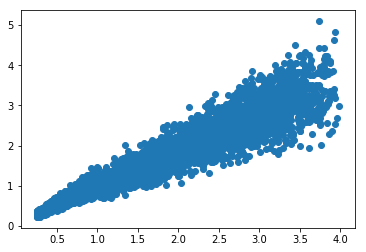

In [12]:
# Visualize how growth rates change with growth iterations
plt.scatter(tmap_annotated.obs['g0'],tmap_annotated.obs['g1'])
plt.show()

When we increase the regularization parameter $\lambda_1$, the row sum constraints are enforced more strictly. 

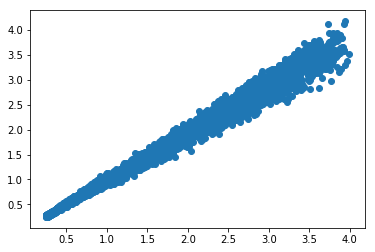

In [13]:
ot_model_strict = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 3,lambda2 = 50) 
tmap_annotated_2 = ot_model_strict.compute_transport_map(7,7.5)
plt.scatter(tmap_annotated_2.obs['g0'],tmap_annotated_2.obs['g1'])
plt.show()

FIXME:
label axis, add header in this plot and one above. 

Compute all transport maps

In [ ]:
ot_model.compute_all_transport_maps(tmap_out='tmaps/serum')